In [1]:
#import numpy as np
import pandas as pd
import json
import configparser
from pathlib import Path
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN

configs = configparser.ConfigParser()
configs.read("configuracoes.conf",encoding='utf-8')
data_folder = Path(configs["DEFAULT"]["folder_path"])
path = data_folder / configs["DEFAULT"]["file"]
objeto = configs["DEFAULT"]["objeto"]
regiao = configs["DEFAULT"]["regiao"]

In [2]:
look_back = 12 #Quantidade de meses anteriores usado para prever
forecast_horizon = int(configs["DEFAULT"]["meses"]) #Quantidade de meses a serem previstos

#Carrega os dados
cesta = pd.read_excel(path)
cesta.drop(['ano', 'salario', 'preco'], axis=1, inplace=True)

#Cria sequencias de tempo de tamanho (meses anteriores + meses a ser previstos)
for n_step in range(1, look_back + forecast_horizon):
    cesta[f'razao t(h + {n_step})'] = cesta['razao'].shift(-n_step).values
cesta.dropna(inplace=True)
cesta.reset_index(drop=True, inplace=True)

#Divide os dados em Treino e Teste
X_train = cesta.iloc[:-1:, :look_back:].values
y_train = cesta.iloc[:-1:, look_back::].values
X_val = cesta.iloc[-1::, :look_back:].values
y_val = cesta.iloc[-1::, look_back::].values

#remodela os dados para formato (batchs, sequencia de tempo, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

#Cria o modelo
model=Sequential()
model.add(SimpleRNN(64, input_shape=(look_back,1)))
model.add(Dense(forecast_horizon))
model.compile(loss='mean_squared_error', optimizer='adam')

#Treina e pever (forecast_horizon) quantidade de tempo
history = model.fit(X_train, y_train, epochs= 7, batch_size=1, shuffle=False)#, validation_data=(X_val, y_val))
forecast = model.predict(X_val)

resultados = [valor for valor in forecast[0]]   
objeto = objeto.replace(" ",'_')
output = {objeto.lower():str(resultados)}
filename = f"previsao_RNN_{objeto.lower()}_{regiao.lower()}_{forecast_horizon}_meses.json"
pasta_atual = os.getcwd()
full_url = Path(pasta_atual) / 'resultados' / 'previsoes' / filename
os.makedirs(os.path.dirname(full_url), exist_ok=True)
with open(full_url,"w") as file:
    json.dump(output,file,ensure_ascii=False)
print("Arquivo com resultados gerados")

Epoch 1/50
186/186 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0028
Epoch 2/50
186/186 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 3/50
186/186 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 4/50
186/186 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 5/50
186/186 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 6/50
186/186 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/50
186/186 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/50
186/186 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/50
186/186 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/50
186/186 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0011

Text(0, 0.5, 'Loss')

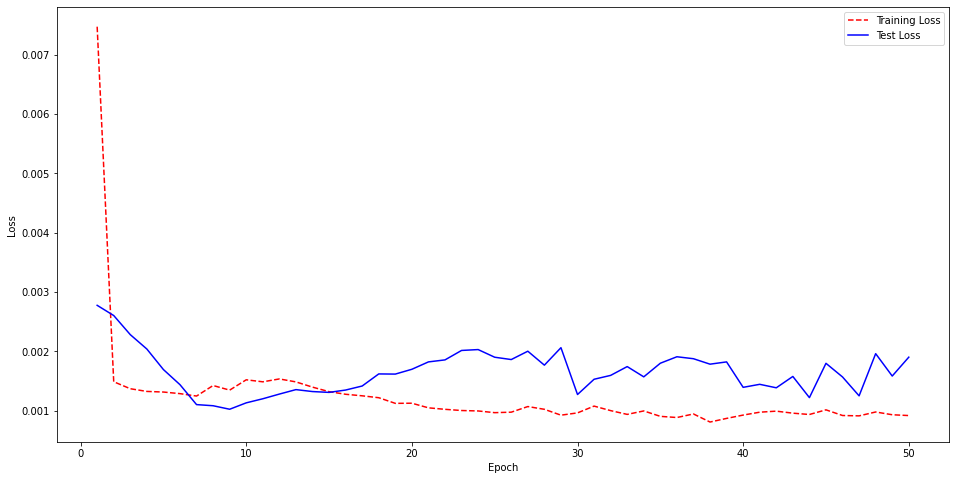

In [3]:

import matplotlib.pyplot as plt

training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
fig = plt.figure(figsize=(16, 8))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
